# Hierarchical clustering

In [ ]:
#| default_exp hierarchical

In [ ]:
#| export
import pandas as pd,numpy as np
from katlas.data import *
from katlas.pssm.core import recover_pssm
from katlas.pssm.compare import js_divergence_flat
from scipy.cluster.hierarchy import fcluster,linkage,dendrogram
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from cachetools import LRUCache

In [ ]:
#| export
def get_Z_custom(df, # Rows=items, cols=features
          metric:str="euclidean", # Distance metric for `pdist`
          method:str|None=None, # Linkage method (auto-chosen if None)
          metric_fn=None, # Custom distance fn (e.g. JS divergence)
         ):
    "Compute hierarchical clustering linkage matrix `Z`."

    X = df.to_numpy(dtype=float)
    method = method or ("ward" if metric=="euclidean" and metric_fn is None else "average")

    if method=="ward":
        if metric!="euclidean" or metric_fn is not None:
            raise ValueError("Ward linkage requires Euclidean distance.")
        return linkage(X, method="ward")

    d = pdist(X, metric=metric_fn or metric)
    return linkage(d, method=method)

In [ ]:
#| export
_Z_CACHE = LRUCache(maxsize=50)

In [ ]:
#| export
def get_Z(df):
    """Return cached linkage matrix for a dataframe."""
    key = id(df)

    if key not in _Z_CACHE:
        X = df.to_numpy(dtype=float)
        _Z_CACHE[key] = linkage(X, method="ward")

    return _Z_CACHE[key]

In [ ]:
df=Data.get_pspa_scale()

In [ ]:
%%time
Z=get_Z(df)

CPU times: user 4.83 ms, sys: 842 μs, total: 5.67 ms
Wall time: 4.84 ms


In [ ]:
#| export
def auto_thr(Z, # Linkage matrix
            percentile=95, # Only consider merge-distance jumps above this percentile.- 90–95: fewer clusters (earlier cut)- 97–99: more clusters (later cut)
            ):
    """
    Pick color threshold at a large jump in linkage distances.
    """
    d = Z[:, 2]
    jumps = np.diff(d)

    # threshold jumps to ignore small/noisy merges
    jump_cutoff = np.percentile(jumps, percentile)

    # candidate indices with large jumps
    candidates = np.where(jumps >= jump_cutoff)[0]
    # fallback: global max jump
    idx = candidates[0] if len(candidates) > 0 else np.argmax(jumps)
    # idx = candidates[-1] if len(candidates) > 0 else np.argmax(jumps)
    
    return d[idx]

In [ ]:
thr=auto_thr(Z)
thr

np.float64(0.5971067774415783)

In [ ]:
#｜ export
def plot_dendrogram(Z,
                    thr=0.07,
                    dense=7, # the higher the more dense for each row
                    line_width=1,
                    title=None,
                    scale=1,
                    **kwargs):
    length = (len(Z) + 1) // dense
    
    plt.figure(figsize=(5*scale,length*scale))
    with plt.rc_context({'lines.linewidth': line_width}):
        dendrogram(
            Z,
            orientation='left',
            leaf_font_size=7,
            color_threshold=thr,
            **kwargs
        )
    if title is not None: plt.title(title)
    plt.xlabel('Distance')
    # plt.savefig(output, bbox_inches='tight')
    # plt.close()
    ax = plt.gca()
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

In [ ]:
# plot_dendrogram(Z,thr=thr)

In [ ]:
#| export
def get_color_groups(Z,  # Linkage matrix
                     thr:float=0.07 # Same threshold as `dendrogram(color_threshold=...)`
                    ):
    "Assign dendrogram color/cluster group IDs."
    return fcluster(Z, thr, criterion='distance')

In [ ]:
# get_color_groups(Z,thr)

In [ ]:
#| export
def get_cluster(df,pct=95,plot=False):
    "Get flat cluster assignments from hierarchical clustering linkage matrix `Z`."
    Z = get_Z(df)
    thr = auto_thr(Z,percentile=pct)
    clusters = fcluster(Z, thr, criterion='distance')
    if plot: plot_dendrogram(Z,labels=df.index,thr=thr)
    return pd.Series(clusters, index=df.index)

kinase
AAK1         7
ACVR2A      49
ACVR2B      49
AKT1        35
AKT2        35
            ..
KDR          5
FLT4         5
WEE1_TYR     1
YES1         2
ZAP70        4
Length: 396, dtype: int32

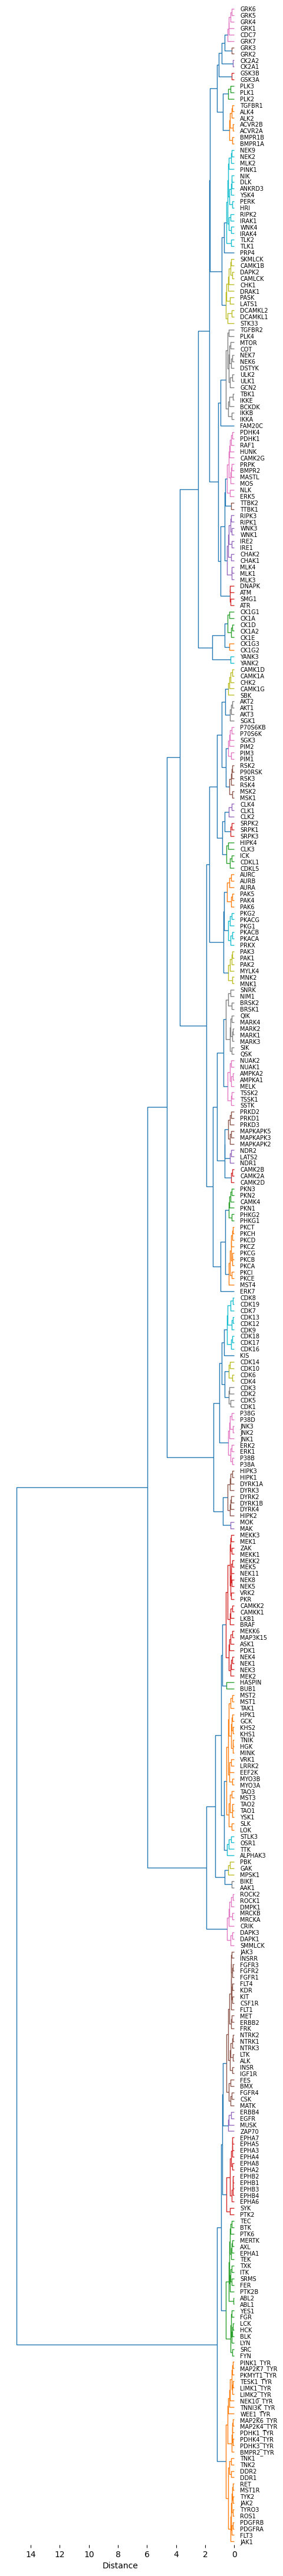

In [ ]:
get_cluster(df,pct=95,plot=True)